In [35]:
# Import necessary libraries
import os
import pickle
import gzip
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

from introdl.utils import get_device
from introdl.idlmam import train_network

# Set device to GPU if available
device = get_device()

# Set random seed for reproducibility
torch.manual_seed(42)

In [36]:
class PublicBusDataset(Dataset):
    def __init__(self, compressed_file, transform=None):
        self.compressed_file = compressed_file
        self.transform = transform
        self.dataset = None  # Lazy-loaded on first access
        self.label_map = {"benign": 0, "malignant": 1}  # Mapping for string labels

        # Preload number of items for __len__ method
        with gzip.open(self.compressed_file, 'rb') as f:
            self.dataset = pickle.load(f)
        self.length = len(self.dataset)
        self.dataset = None  # Free memory

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Load the dataset lazily if not already loaded
        if self.dataset is None:
            with gzip.open(self.compressed_file, 'rb') as f:
                self.dataset = pickle.load(f)

        # Retrieve the specific sample
        sample = self.dataset[idx]

        # Decompress image and convert it to RGB
        image_np = cv2.imdecode(np.frombuffer(sample['image'], np.uint8), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

        # Get bounding box and label
        x_min, y_min, x_max, y_max = sample['x_min'], sample['y_min'], sample['x_max'], sample['y_max']
        label = self.label_map[sample['label']]  # Convert string label to integer

        # Prepare bounding box and labels in target format
        target = {
            "boxes": torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32),
            "labels": [label]  # Convert label to a list for compatibility with Albumentations
        }

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, bboxes=target["boxes"].numpy(), category_ids=target["labels"])
            image = augmented["image"]
            target["boxes"] = torch.tensor(augmented["bboxes"], dtype=torch.float32)
            target["labels"] = torch.tensor(augmented["category_ids"], dtype=torch.int64)

        return (image, target), None  # Return ((image, target), None) for compatibility with train_network



In [37]:
# Define transformations for data augmentation
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=20, shift_limit=0.2, p=0.5),  # This affects both image and bbox
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))


test_transform = A.Compose([
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

# Initialize dataset
compressed_file = "../../data/public_bus_dataset.pkl.gz"
dataset = PublicBusDataset(compressed_file=compressed_file, transform=train_transform)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Set test transform for validation and test sets
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

/Users/jbaggett/miniforge3/envs/DS776v2/lib/python3.11/site-packages/albumentations/core/composition.py:243: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [42]:
def plot_sample(image, target):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Check if the image is already uint8 with the correct range
    if image.dtype == torch.uint8 and image.min().item() >= 0 and image.max().item() <= 255:
        image_np = image.permute(1, 2, 0).cpu().numpy()
    else:
        # Convert to range 0-255 for display
        image_np = image.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()

    # Ensure color order is RGB
    if image_np.shape[2] == 3:  # Check for RGB or grayscale
        image_np = image_np[:, :, [2, 1, 0]]  # Convert BGR to RGB if needed
    
    ax.imshow(image_np)
    
    # Plot bounding boxes and labels
    boxes = target["boxes"].cpu().numpy()
    labels = target["labels"].cpu().numpy()
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   fill=False, color="red", linewidth=2))
        ax.text(x_min, y_min, str(label), color="white", fontsize=12, 
                bbox=dict(facecolor="red", alpha=0.5))
    
    plt.axis("off")
    plt.show()


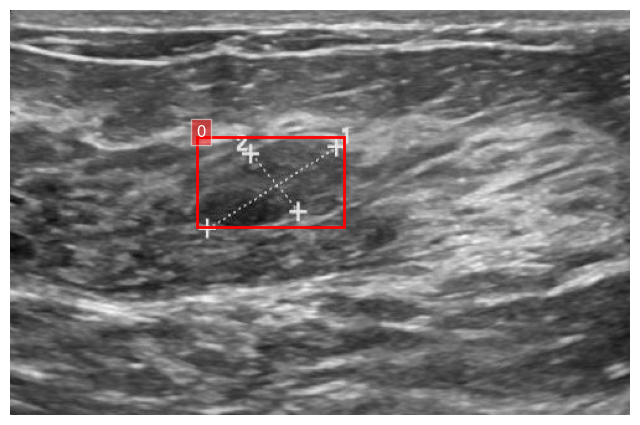

In [48]:
plot_sample(*test_dataset[10][0])

In [ ]:

# Define Faster R-CNN with MobileNetV3 backbone
def get_model(num_classes):
    model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Define model wrapper to handle input with or without targets
class FasterRCNNWrapper(torch.nn.Module):
    def __init__(self, model):
        super(FasterRCNNWrapper, self).__init__()
        self.model = model

    def forward(self, inputs, targets=None):
        # Unpack images and targets if they are packed in a tuple
        if isinstance(inputs, tuple) and len(inputs) == 2:
            images, targets = inputs  # Unpack images and targets in training mode
        else:
            images = inputs  # Just images in eval mode

        # In training, pass both images and targets for loss calculation
        if self.training and targets is not None:
            return self.model(images, targets)
        # In eval mode, pass only images for predictions
        else:
            return self.model(images)

# Initialize and wrap the Faster R-CNN model
num_classes = 2  # Assume binary classification: 1 for object, 0 for background
model = get_model(num_classes)
wrapped_model = FasterRCNNWrapper(model)

# Define optimizer and scheduler
# optimizer = torch.optim.SGD(wrapped_model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.AdamW(wrapped_model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Custom loss function for Faster R-CNN
def faster_rcnn_loss(output, target):
    return sum(loss for loss in output.values())

# Individual scoring functions for train_network
score_funcs = {
    "precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average="weighted"),
    "recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average="weighted"),
    "fscore": lambda y_true, y_pred: f1_score(y_true, y_pred, average="weighted")
}

# Run training using train_network
results_df = train_network(
    model=wrapped_model,
    loss_func=faster_rcnn_loss,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    score_funcs=score_funcs,
    epochs=10,
    device=device,
    checkpoint_file="faster_rcnn_checkpoint.pth",
    lr_schedule=scheduler,
    optimizer=optimizer,
    grad_clip=1.0  # Optional gradient clipping
)

# Display results DataFrame
print(results_df)

# Visualization function to display images with predictions
def plot_sample(image, target):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    image_np = image.mul(255).permute(1, 2, 0).byte().cpu().numpy()
    ax.imshow(image_np)

    boxes = target["boxes"].cpu().numpy()
    labels = target["labels"].cpu().numpy()
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   fill=False, color="red", linewidth=2))
        ax.text(x_min, y_min, str(label), color="white", fontsize=12, 
                bbox=dict(facecolor="red", alpha=0.5))
    plt.axis("off")
    plt.show()

# Display random predictions on test set
wrapped_model.eval()
with torch.no_grad():
    for images, targets in random.sample(list(test_loader), 3):  # Show 3 random samples
        images = [image.to(device) for image in images]
        outputs = wrapped_model(images)
        for img, output in zip(images, outputs):
            plot_sample(img, output)


# Complete with Training Loop

In [11]:
# Import necessary libraries
import os
import cv2
import torch
import random
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_score, recall_score, f1_score

from introdl.utils import get_device

# Set device to GPU if available
device = get_device()
device = torch.device('cpu')
torch.manual_seed(42)

In [12]:
class PublicBusDataset(Dataset):
    def __init__(self, compressed_file, transform=None):
        self.compressed_file = compressed_file
        self.transform = transform
        self.dataset = None  # Lazy-loaded on first access
        self.label_map = {"benign": 0, "malignant": 1}  # Map string labels to integers

        # Preload number of items for __len__ method
        with gzip.open(self.compressed_file, 'rb') as f:
            self.dataset = pickle.load(f)
        self.length = len(self.dataset)
        self.dataset = None  # Free memory

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Load the dataset lazily if not already loaded
        if self.dataset is None:
            with gzip.open(self.compressed_file, 'rb') as f:
                self.dataset = pickle.load(f)

        # Retrieve the specific sample
        sample = self.dataset[idx]

        # Decode the image from bytes to numpy array
        image_np = cv2.imdecode(np.frombuffer(sample['image'], np.uint8), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)  # Convert to RGB format

        # Extract bounding box and convert label from string to integer
        x_min, y_min, x_max, y_max = sample['x_min'], sample['y_min'], sample['x_max'], sample['y_max']
        label = self.label_map[sample['label']]  # Convert label to integer

        # Prepare the target dictionary
        target = {
            "boxes": torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32),
            "labels": torch.tensor([label], dtype=torch.int64)
        }

        # Apply transformations if specified
        if self.transform:
            augmented = self.transform(image=image, bboxes=target["boxes"].numpy(), category_ids=target["labels"].tolist())
            image = augmented["image"]
            target["boxes"] = torch.tensor(augmented["bboxes"], dtype=torch.float32)
            target["labels"] = torch.tensor(augmented["category_ids"], dtype=torch.int64)

        return image, target


In [13]:


# Define transformations for data augmentation
''' 
# without imagenet normalization
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=20, shift_limit=0.2, p=0.5),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

test_transform = A.Compose([ToTensorV2()], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))
'''

# with imagenet normalization
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=20, shift_limit=0.2, p=0.5),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

test_transform = A.Compose([
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))


# Initialize dataset
compressed_file = "../../data/public_bus_dataset.pkl.gz"
dataset = PublicBusDataset(compressed_file=compressed_file, transform=train_transform)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Set test transform for validation and test sets
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# return lists of images and targets because images have variable sizes
def custom_collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)



/Users/jbaggett/miniforge3/envs/DS776v2/lib/python3.11/site-packages/albumentations/core/composition.py:243: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [14]:

# Define Faster R-CNN with MobileNetV3 backbone
def get_model(num_classes):
    model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [15]:
# Initialize model, optimizer, and learning rate scheduler
num_classes = 2  # Assume binary classification: 1 for object, 0 for background
model = get_model(num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/Users/jbaggett/miniforge3/envs/DS776v2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jbaggett/miniforge3/envs/DS776v2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [17]:
# Training and validation loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)  # Faster R-CNN returns loss dict in training
        losses = sum(loss for loss in loss_dict.values())
        train_loss += losses.item()

        losses.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            val_loss += sum(loss for loss in loss_dict.values()).item()
    
    val_loss /= len(val_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

KeyboardInterrupt: 

In [ ]:
# Testing and Metrics Calculation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, targets in test_loader:
        images = list(image.to(device) for image in images)
        predictions = model(images)

        # Process predictions and true labels
        for pred, target in zip(predictions, targets):
            pred_labels = pred['labels'].cpu().numpy()
            true_labels = target['labels'].numpy()

            all_preds.extend(pred_labels)
            all_labels.extend(true_labels)

# Calculate precision, recall, and f1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")



In [ ]:
# Function to visualize predictions
def plot_sample(image, target):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Check if the image is already uint8 with the correct range
    if image.dtype == torch.uint8 and image.min().item() >= 0 and image.max().item() <= 255:
        image_np = image.permute(1, 2, 0).cpu().numpy()
    else:
        image_np = image.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()

    if image_np.shape[2] == 3:
        image_np = image_np[:, :, [2, 1, 0]]  # Convert BGR to RGB if needed
    
    ax.imshow(image_np)
    
    # Plot bounding boxes and labels
    boxes = target["boxes"].cpu().numpy()
    labels = target["labels"].cpu().numpy()
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   fill=False, color="red", linewidth=2))
        ax.text(x_min, y_min, str(label), color="white", fontsize=12, 
                bbox=dict(facecolor="red", alpha=0.5))
    
    plt.axis("off")
    plt.show()

# Visualize predictions on random test samples
model.eval()
with torch.no_grad():
    for images, targets in random.sample(list(test_loader), 3):
        images = [image.to(device) for image in images]
        predictions = model(images)
        for img, pred in zip(images, predictions):
            plot_sample(img, pred)


# Complete Notebook Version 2

In [ ]:
import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.transforms import functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import pickle
import gzip
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score

# Custom Dataset Class
class PublicBusDataset(Dataset):
    def __init__(self, compressed_file, transform=None):
        self.compressed_file = compressed_file
        self.transform = transform
        self.dataset = None  # Lazy-loaded on first access
        self.label_map = {"benign": 0, "malignant": 1}  # Map string labels to integers

        # Preload number of items for __len__ method
        with gzip.open(self.compressed_file, 'rb') as f:
            self.dataset = pickle.load(f)
        self.length = len(self.dataset)
        self.dataset = None  # Free memory

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Load the dataset lazily if not already loaded
        if self.dataset is None:
            with gzip.open(self.compressed_file, 'rb') as f:
                self.dataset = pickle.load(f)

        # Retrieve the specific sample
        sample = self.dataset[idx]

        # Decode the image from bytes to numpy array
        image_np = cv2.imdecode(np.frombuffer(sample['image'], np.uint8), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)  # Convert to RGB format

        # Extract bounding box and convert label from string to integer
        x_min, y_min, x_max, y_max = sample['x_min'], sample['y_min'], sample['x_max'], sample['y_max']
        label = self.label_map[sample['label']]  # Convert label to integer

        # Prepare the target dictionary
        target = {
            "boxes": torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32),
            "labels": torch.tensor([label], dtype=torch.int64)
        }

        # Apply transformations if specified
        if self.transform:
            augmented = self.transform(image=image, bboxes=target["boxes"].numpy(), category_ids=target["labels"].tolist())
            image = augmented["image"]
            target["boxes"] = torch.tensor(augmented["bboxes"], dtype=torch.float32)
            target["labels"] = torch.tensor(augmented["category_ids"], dtype=torch.int64)

        return image, target

# Define transformations
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.3),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(512, 512),
    ToTensorV2()
])

# Load the dataset
compressed_file = "../../data/public_bus_dataset.pkl.gz"
dataset = PublicBusDataset(compressed_file=compressed_file, transform=train_transform)

# Split into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Set test transform for validation and test sets
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Define the model
num_classes = 2  # Background and two object classes
model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torch.nn.Linear(in_features, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training and validation loop
num_epochs = 10

for epoch in range(num_epochs):
    # Training Loop
    model.train()
    train_loss = 0.0
    
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)  # Faster R-CNN returns loss dict in training mode
        losses = sum(loss for loss in loss_dict.values())
        train_loss += losses.item()

        losses.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}")

    # Validation Loop
    val_loss = 0.0
    model.train()  # Switch to train mode to get loss (safe with torch.no_grad())
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Compute validation loss
            loss_dict = model(images, targets)
            val_loss += sum(loss for loss in loss_dict.values()).item()
    
    val_loss /= len(val_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

# Function to plot sample with predictions and true boxes
def plot_sample(image, target, prediction=None, denormalize=True):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # ImageNet mean and std for denormalization
    imagenet_mean = torch.tensor([0.485, 0.456, 0.406], device=image.device)
    imagenet_std = torch.tensor([0.229, 0.224, 0.225], device=image.device)

    if denormalize:
        # Reverse normalization: (image * std) + mean
        image = image * imagenet_std[:, None, None] + imagenet_mean[:, None, None]
    
    # Check if the image is already uint8 with the correct range
    if image.dtype == torch.uint8 and image.min().item() >= 0 and image.max().item() <= 255:
        image_np = image.permute(1, 2, 0).cpu().numpy()
    else:
        # Convert to range 0-255 for display
        image_np = image.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()

    # Ensure color order is RGB
    if image_np.shape[2] == 3:  # Check for RGB or grayscale
        image_np = image_np[:, :, [2, 1, 0]]  # Convert BGR to RGB if needed
    
    ax.imshow(image_np)
    
    # Plot ground truth bounding boxes and labels in blue
    true_boxes = target["boxes"].cpu().numpy()
    true_labels = target["labels"].cpu().numpy()
    for box, label in zip(true_boxes, true_labels):
        x_min, y_min, x_max, y_max = box
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   fill=False, color="blue", linewidth=2))
        ax.text(x_min, y_min, str(label), color="white", fontsize=12, 
                bbox=dict(facecolor="blue", alpha=0.5))
    
    # Plot predicted bounding boxes and labels in red (if provided)
    if prediction:
        pred_boxes = prediction["boxes"].cpu().numpy()
        pred_labels = prediction["labels"].cpu().numpy()
        for box, label in zip(pred_boxes, pred_labels):
            x_min, y_min, x_max, y_max = box
            ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                       fill=False, color="red", linewidth=2))
            ax.text(x_min, y_min, str(label), color="white", fontsize=12, 
                    bbox=dict(facecolor="red", alpha=0.5))
    
    plt.axis("off")
    plt.show()

# Visualize predictions and true labels on random test samples
model.eval()
with torch.no_grad():
    for images, targets in random.sample(list(test_loader), 3):
        images = [image.to(device) for
